In [1]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error
from scipy.stats import pearsonr
from itertools import combinations
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBRegressor
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error
import optuna
from joblib import dump, load
import shap


In [2]:
## Functions
def evaluate_linear_baseline(data, base_features, max_degree=2, combo_size=5):
    results = []

    # Crear bloques temporales
    all_weeks = sorted(data['week'].dropna().unique())
    week_blocks = [all_weeks[i:i+26] for i in range(0, len(all_weeks), 26)]

    # Probar combinaciones de variables
    for feature_combo in combinations(base_features, combo_size):
        feature_combo = list(feature_combo)

        for degree in range(1, max_degree+1):
            rmses_train, rmses_test, corrs_train, corrs_test = [], [], [], []

            for week_block in week_blocks:
                fold_test = data[data['week'].isin(week_block)].copy()
                fold_train = data[~data['week'].isin(week_block)].copy()

                if fold_test.empty or fold_train.empty:
                    continue

                try:
                    # Subset y eliminar NaNs
                    train_subset = fold_train[feature_combo + ['Precipitacion']].dropna()
                    test_subset = fold_test[feature_combo + ['Precipitacion']].dropna()

                    if train_subset.empty or test_subset.empty:
                        continue

                    # Separar X e y
                    X_train_raw = train_subset[feature_combo]
                    y_train = train_subset['Precipitacion']

                    X_test_raw = test_subset[feature_combo]
                    y_test = test_subset['Precipitacion']

                    # Transformaciones polinómicas
                    poly = PolynomialFeatures(degree=degree, include_bias=False)
                    X_train = poly.fit_transform(X_train_raw)
                    X_test = poly.transform(X_test_raw)
                    
                    

                    # Entrenar modelo
                    model_linear = LinearRegression()
                    
                    model_linear.fit(X_train, y_train)

                    # Predicciones
                    preds_train = model_linear.predict(X_train)
                    preds_test = model_linear.predict(X_test)

                    # RMSE
                    rmse_train = np.sqrt(mean_squared_error(y_train, preds_train))
                    rmse_test = np.sqrt(mean_squared_error(y_test, preds_test))

                    # Correlaciones protegidas
                    valid_train = ~np.isnan(y_train) & ~np.isnan(preds_train)
                    valid_test = ~np.isnan(y_test) & ~np.isnan(preds_test)

                    corr_train = pearsonr(y_train[valid_train], preds_train[valid_train])[0] if valid_train.sum() > 1 else np.nan
                    corr_test = pearsonr(y_test[valid_test], preds_test[valid_test])[0] if valid_test.sum() > 1 else np.nan

                    # Guardar métricas
                    rmses_train.append(rmse_train)
                    rmses_test.append(rmse_test)
                    corrs_train.append(corr_train)
                    corrs_test.append(corr_test)

                except Exception as e:
                    # Salta bloque si algo falla (opcional)
                    print(f"[WARN] Falló combo {feature_combo} con grado {degree}: {e}")
                    continue

            # Guardar resumen del fold
            results.append({
                'features': feature_combo,
                'degree': degree,
                'rmse_train': np.nanmean(rmses_train),
                'rmse_test': np.nanmean(rmses_test),
                'corr_train': np.nanmean(corrs_train),
                'corr_test': np.nanmean(corrs_test)
            })

    return pd.DataFrame(results)

In [3]:
df = pd.read_parquet("D:/OneDrive - CGIAR/Desktop/downscaling/data/features/precip_features.parquet")
df.shape

(9823, 20)

In [4]:
df.columns

Index(['Estacion', 'year', 'week', 'Precipitacion', 'Latitud', 'Longitud',
       'epi_week', 'tmax_saga', 'tmin_saga', 'slope', 'aspect', 'tpi',
       'cumbre', 'valle', 'rugosity', 'dem', 'ndvi', 'ndwi', 'chirps',
       'chirps_1km'],
      dtype='object')

## Regresión Lineal 

In [5]:
# Crear week_sin y week_cos
df['week_sin'] = np.sin(2 * np.pi * df['week'] / 52)
df['week_cos'] = np.cos(2 * np.pi * df['week'] / 52)
df["chirps_dem"]    = df.chirps_1km * df.dem
df["ndvi_rugosity"] = df.ndvi     * df.rugosity
df["tpi2"]          = df.tpi      ** 2
df = df[df["Precipitacion"] <= 700]

In [6]:
base_vars = ['tmax_saga', 'tmin_saga', 'slope', 'aspect', 'tpi', 'cumbre', 'valle', 'rugosity', 'dem', 'ndvi',"ndwi","chirps_1km"]
# Evaluar
resultados_baseline = evaluate_linear_baseline(df, base_vars, max_degree=2, combo_size=5)

# Ver los mejores resultados ordenados
resultados_baseline.sort_values(by='rmse_test').head(10)

features  degree  rmse_train  \
737         [tmin_saga, slope, tpi, valle, chirps_1km]       2   33.913039   
907   [tmin_saga, aspect, valle, rugosity, chirps_1km]       2   33.917709   
949        [tmin_saga, tpi, cumbre, valle, chirps_1km]       2   34.129786   
849        [tmin_saga, aspect, tpi, valle, chirps_1km]       2   34.186525   
977      [tmin_saga, tpi, valle, rugosity, chirps_1km]       2   33.983893   
1017  [tmin_saga, cumbre, valle, rugosity, chirps_1km]       2   33.934082   
695      [tmin_saga, slope, aspect, valle, chirps_1km]       2   33.909069   
983           [tmin_saga, tpi, valle, dem, chirps_1km]       2   33.995714   
767      [tmin_saga, slope, cumbre, valle, chirps_1km]       2   33.919334   
1055     [tmin_saga, valle, rugosity, dem, chirps_1km]       2   34.102939   

      rmse_test  corr_train  corr_test  
737   25.995199    0.485309   0.471188  
907   26.051161    0.484997   0.457353  
949   26.120278    0.474962   0.424621  
849   26.126769    0.472325   0.451480  
977   26.128921    0.482030   0.472345  
1017  26.150165    0.484198   0.446776  
695   26.169041    0.485391   0.435321  
983   26.205664    0.481387   0.436838  
767   26.216632    0.484908   0.437644  
1055  26.246183    0.476380   0.414711

## Ajuste con el mejor modelo lineal

In [7]:
# Mejores features y grado encontrado
mejores_vars = ["tmin_saga", "slope", "tpi", "valle", "chirps_1km"]
grado = 2

# Filtrar datos y quitar NaNs
df_modelo = df[mejores_vars + ['Precipitacion']].dropna()

X_raw = df_modelo[mejores_vars]
y_true = df_modelo['Precipitacion']

# Transformación polinómica
poly = PolynomialFeatures(degree=grado, include_bias=False)
X_poly = poly.fit_transform(X_raw)

# Ajustar modelo
modelo_final_lin = LinearRegression()
modelo_final_lin.fit(X_poly, y_true)

# Predecir sobre todos los datos
y_pred = modelo_final_lin.predict(X_poly)

In [8]:
rmse = np.sqrt(mean_squared_error(y_true, y_pred))
pearson_corr = pearsonr(y_true, y_pred)[0]
print("RMSE:",rmse)
print("Correlación Pearson:",pearson_corr)

RMSE: 33.97448694174497
Correlación Pearson: 0.4863055146005296


C:\Users\dagudelo\AppData\Local\Temp\ipykernel_16916\1973881928.py:18: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


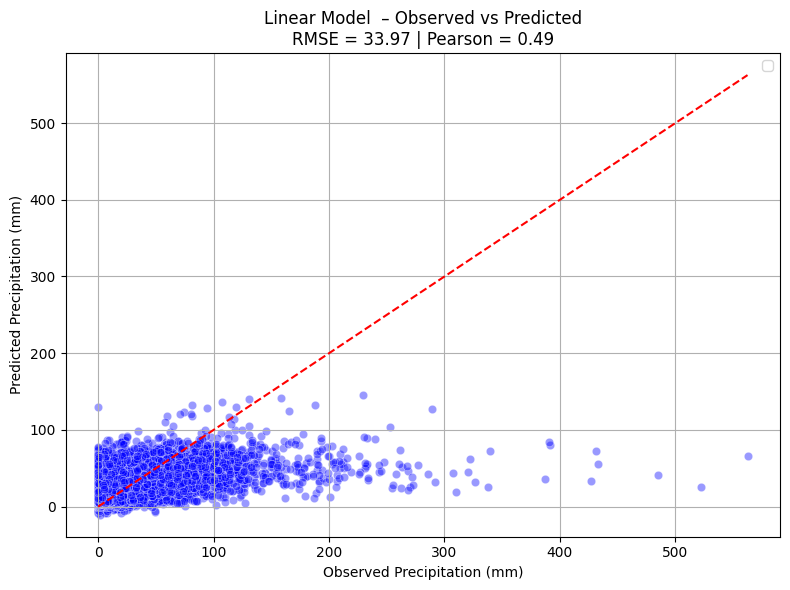

In [9]:
# Crear DataFrame para graficar
precip_resul_linear = pd.DataFrame({
    'precip': y_true,
    'precip_pred': y_pred
})

# Graficar
plt.figure(figsize=(8,6))
sns.scatterplot(x='precip', y='precip_pred', data=precip_resul_linear, alpha=0.4, color="blue")
plt.plot([precip_resul_linear['precip'].min(), precip_resul_linear['precip'].max()],
         [precip_resul_linear['precip'].min(), precip_resul_linear['precip'].max()],
         'r--', label='')

plt.xlabel("Observed Precipitation (mm)")
plt.ylabel("Predicted Precipitation (mm)")
plt.title(f"Linear Model  – Observed vs Predicted\nRMSE = {rmse:.2f} | Pearson = {pearson_corr:.2f}")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

## Xgboost 

In [10]:
df.columns

Index(['Estacion', 'year', 'week', 'Precipitacion', 'Latitud', 'Longitud',
       'epi_week', 'tmax_saga', 'tmin_saga', 'slope', 'aspect', 'tpi',
       'cumbre', 'valle', 'rugosity', 'dem', 'ndvi', 'ndwi', 'chirps',
       'chirps_1km', 'week_sin', 'week_cos', 'chirps_dem', 'ndvi_rugosity',
       'tpi2'],
      dtype='object')

## Optimización bayesiana en paralelo

In [ ]:
# optuna_downscaling_parallel.py
# Correr en un servidor

import optuna
import numpy as np
import pandas as pd
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
from scipy.stats import pearsonr
from joblib import Parallel, delayed
import os


features = [
    "chirps_1km", "chirps", "tmax_saga", "tmin_saga", "slope", "aspect",
    "tpi", "cumbre", "valle", "rugosity", "dem", "ndvi", "ndwi",
    "week_sin", "week_cos", "Latitud", "Longitud",
    "chirps_dem", "ndvi_rugosity", "tpi2"
]
target = "Precipitacion"

print("✅ Cargando datos...")
df = df.dropna(subset=features + [target])
X = df[features].values
y = df[target].values
stations = df["Estacion"].values
weeks = df["epi_week"].values
uniq_weeks = np.sort(np.unique(weeks))

# ---------------------- 2. EVALUACION PARALALA POR FOLD ----------------------
def evaluate_fold(X, y, weeks, stations, blk, st, params):
    mask_w = np.isin(weeks, blk)
    mask_te_blk = mask_w & (stations == st)
    mask_tr_blk = ~mask_te_blk
    if mask_te_blk.sum() == 0 or mask_tr_blk.sum() == 0:
        return None

    model = XGBRegressor(**params)
    model.fit(X[mask_tr_blk], y[mask_tr_blk])
    y_tr_p = model.predict(X[mask_tr_blk])
    y_te_p = model.predict(X[mask_te_blk])
    y_tr_r = y[mask_tr_blk]
    y_te_r = y[mask_te_blk]

    rm_tr = np.sqrt(mean_squared_error(y_tr_r, y_tr_p))
    rm_te = np.sqrt(mean_squared_error(y_te_r, y_te_p))
    r_tr_val = pearsonr(y_tr_r, y_tr_p)[0] if len(np.unique(y_tr_r)) > 1 else np.nan
    r_te_val = pearsonr(y_te_r, y_te_p)[0] if len(np.unique(y_te_r)) > 1 else np.nan
    return rm_tr, rm_te, r_tr_val, r_te_val

def spatiotemporal_cv_rmse(params, X, y, weeks, stations, uniq_weeks):
    week_blocks = [uniq_weeks[i:i+26] for i in range(0, len(uniq_weeks), 26)]
    tasks = [(blk, st) for blk in week_blocks for st in np.unique(stations[np.isin(weeks, blk)])]

    results = Parallel(n_jobs=-1)(
        delayed(evaluate_fold)(X, y, weeks, stations, blk, st, params)
        for blk, st in tasks
    )
    results = [r for r in results if r is not None]
    if not results:
        return float('inf')

    rms_tr, rms_te, r_tr, r_te = zip(*results)
    mean_rmse_te = np.mean(rms_te)
    mean_rmse_tr = np.mean(rms_tr)
    mean_r_te = np.nanmean(r_te)
    mean_r_tr = np.nanmean(r_tr)

    print(f"\u2705 Train: RMSE={mean_rmse_tr:.2f}, r={mean_r_tr:.3f} | Test: RMSE={mean_rmse_te:.2f}, r={mean_r_te:.3f}")

    rmse_gap = mean_rmse_te - mean_rmse_tr
    r_gap = np.abs(mean_r_te - mean_r_tr)
    loss = mean_rmse_te + 0.5 * rmse_gap + 0.3 * r_gap + 0.2 * (1 - abs(mean_r_te))
    return loss

# ---------------------- 3. FUNCION OBJETIVO ----------------------
def objective(trial):
    params = {
        "objective": "reg:tweedie",
        "tweedie_variance_power": trial.suggest_float("tweedie_variance_power", 1.3, 2.0),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.2),
        "n_estimators": trial.suggest_int("n_estimators", 500, 1500),
        "max_depth": trial.suggest_int("max_depth", 2, 6),
        "min_child_weight": trial.suggest_int("min_child_weight", 1, 10),
        "gamma": trial.suggest_float("gamma", 0.0, 1.0),
        "subsample": trial.suggest_float("subsample", 0.5, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),
        "reg_lambda": trial.suggest_float("reg_lambda", 0.1, 5.0),
        "random_state": 42,
        "n_jobs": 1
    }
    loss = spatiotemporal_cv_rmse(params, X, y, weeks, stations, uniq_weeks)
    print(f"\n🎯 Trial {trial.number} terminado con pérdida compuesta: {loss:.4f}\n")
    return loss

# ---------------------- 4. CALLBACK ----------------------
def logging_callback(study, trial):
    print(f"📌 Trial {trial.number} → score: {trial.value:.4f}")
    print(f"🏆 Mejor hasta ahora: Trial {study.best_trial.number} con {study.best_value:.4f}")

# ---------------------- 5. CONFIGURAR Y EJECUTAR ----------------------
storage_path = "sqlite:///C:/Users/DAgudelo/Desktop/resul_bayes_opt/optuna_downscaling.db"
study = optuna.create_study(direction="minimize", storage=storage_path, load_if_exists=True)
study.optimize(objective, n_trials=50, n_jobs=12, show_progress_bar=True, callbacks=[logging_callback])

# ---------------------- 6. RESULTADOS Y GUARDADO ----------------------
print("\n✅ Optimización finalizada")
print("📌 Mejores hiperparámetros:")
print(study.best_params)
print(f"🎯 Pérdida compuesta mínima: {study.best_value:.4f}")

results_path = "C:/Users/DAgudelo/Desktop/resul_bayes_opt/optuna_trials_results.csv"
study.trials_dataframe().to_csv(results_path, index=False)
print(f"📁 Resultados guardados en {results_path}")

## Mejor corrida Xgboost

In [14]:
# Validación cruzada espaciotemporal con impresión
def spatiotemporal_cv_rmse(params, X, y, weeks, stations, uniq_weeks):
    week_blocks = [uniq_weeks[i:i+26] for i in range(0, len(uniq_weeks), 26)]
    rms_tr, rms_te = [], []
    r_tr, r_te = [], []

    for blk in week_blocks:
        mask_w = np.isin(weeks, blk)
        st_blocks = np.unique(stations[mask_w])
        
        for st in st_blocks:
            mask_te_blk = mask_w & (stations == st)
            mask_tr_blk = ~mask_te_blk
            if mask_te_blk.sum() == 0 or mask_tr_blk.sum() == 0:
                continue
            
            model = XGBRegressor(**params)
            model.fit(X[mask_tr_blk], y[mask_tr_blk])
            
            y_tr_p = model.predict(X[mask_tr_blk])
            y_te_p = model.predict(X[mask_te_blk])
            y_tr_r = y[mask_tr_blk]
            y_te_r = y[mask_te_blk]
            
            rm_tr = np.sqrt(mean_squared_error(y_tr_r, y_tr_p))
            rm_te = np.sqrt(mean_squared_error(y_te_r, y_te_p))
            r_tr_val = pearsonr(y_tr_r, y_tr_p)[0] if len(np.unique(y_tr_r)) > 1 else np.nan
            r_te_val = pearsonr(y_te_r, y_te_p)[0] if len(np.unique(y_te_r)) > 1 else np.nan
            
            rms_tr.append(rm_tr); rms_te.append(rm_te)
            r_tr.append(r_tr_val); r_te.append(r_te_val)
    
    # Imprimir promedio de cada corrida
    print(f"Train: RMSE={np.mean(rms_tr):.2f}, r={np.nanmean(r_tr):.3f} | "
          f"Test: RMSE={np.mean(rms_te):.2f}, r={np.nanmean(r_te):.3f}")
    
    return np.mean(rms_te)  # Minimizar RMSE de test
best_params = {
    "objective":        "reg:tweedie",
    "tweedie_variance_power": 1.5,
    "learning_rate":    0.0545,
    "n_estimators":     1500, #1500
    "max_depth":        3,
    "subsample":        0.78,
    "colsample_bytree": 0.61,
    "min_child_weight": 9,
    "gamma":            0.62,
    "reg_lambda":       2.08,
    "random_state":     42,
    "n_jobs":           -1
}
features = [
    "chirps_1km","chirps","tmax_saga","tmin_saga","slope","aspect",
    "tpi","cumbre","valle","rugosity","dem","ndvi","ndwi",
    "week_sin","week_cos","Latitud","Longitud",
    # tus interacciones
    "chirps_dem","ndvi_rugosity","tpi2"
]
target = "Precipitacion"
df = df.dropna(subset=features + [target])
X = df[features].values
y = df[target].values

stations = df["Estacion"].values
weeks    = df["epi_week"].values
uniq_weeks = np.sort(np.unique(weeks))
spatiotemporal_cv_rmse(best_params, X, y, weeks, stations, uniq_weeks)


Train: RMSE=23.19, r=0.818 | Test: RMSE=26.60, r=0.589


np.float64(26.5989606883233)

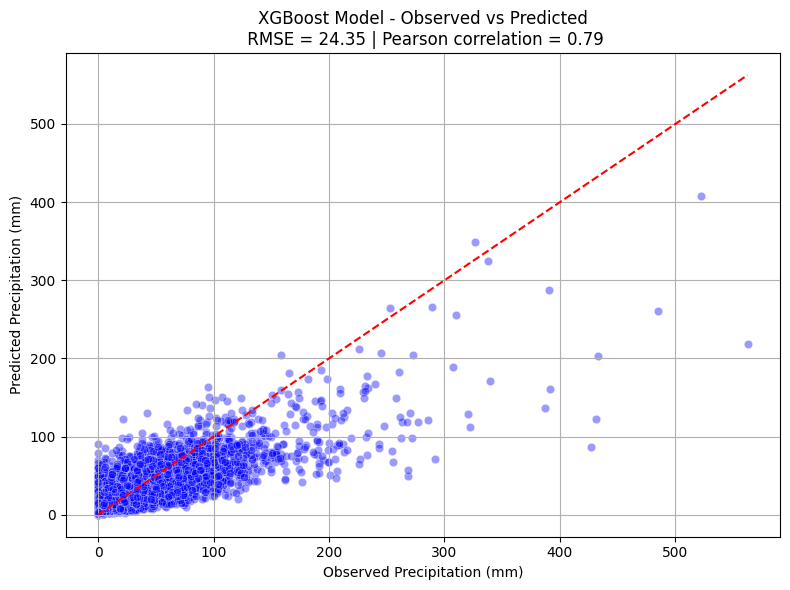

=== Comparación de modelos en Test ===
XGBoost Mejorado: RMSE = 24.35 mm, Pearson r = 0.79


In [16]:

best_params = {
    "objective":        "reg:tweedie",
    "tweedie_variance_power": 1.5,
    "learning_rate":    0.0545,
    "n_estimators":     1500, #1500
    "max_depth":        3,
    "subsample":        0.78,
    "colsample_bytree": 0.61,
    "min_child_weight": 9,
    "gamma":            0.62,
    "reg_lambda":       2.08,
    "random_state":     42,
    "n_jobs":           -1
}


features = sorted([
    "chirps_1km", "tmax_saga", "tmin_saga", "tpi", "cumbre", "ndwi",
    "week_sin", "Latitud", "Longitud",
    "ndvi_rugosity", "tpi2"
])
target = "Precipitacion"
df = df.dropna(subset=features + [target])


X = df[features]
y = df[target]


final_model = XGBRegressor(**best_params)
final_model.fit(X, y)

y_pred_xgb = final_model.predict(X)

df['precip_xgboost'] = final_model.predict(X)

import matplotlib.pyplot as plt
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

from sklearn.metrics import mean_squared_error
from scipy.stats import pearsonr

rmse = np.sqrt(mean_squared_error(y, y_pred_xgb))
pearson_corr = pearsonr(y, y_pred_xgb)[0]

# Crear DataFrame para graficar
precip_resul = pd.DataFrame({
    'precip': y,
    'precip_pred': y_pred_xgb
})

plt.figure(figsize=(8,6))
sns.scatterplot(x='precip', y='precip_pred', data=precip_resul, alpha=0.4,color="blue")
plt.plot([precip_resul['precip'].min(), precip_resul['precip'].max()], [precip_resul['precip'].min(), precip_resul['precip'].max()], 'r--')
plt.xlabel("Observed Precipitation (mm)")
plt.ylabel("Predicted Precipitation (mm)")
plt.title(f"XGBoost Model - Observed vs Predicted\n RMSE = {rmse:.2f} | Pearson correlation = {pearson_corr:.2f}")
plt.grid(True)
plt.tight_layout()
plt.show()



# --- 6) Calcular métricas ---
def metrics(name, y_true, y_pred):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r, _  = pearsonr(y_true, y_pred)
    print(f"{name}: RMSE = {rmse:.2f} mm, Pearson r = {r:.2f}")

print("=== Comparación de modelos en Test ===")
metrics("XGBoost Mejorado"  , y, y_pred_xgb)

## Shapply Values Xgboost

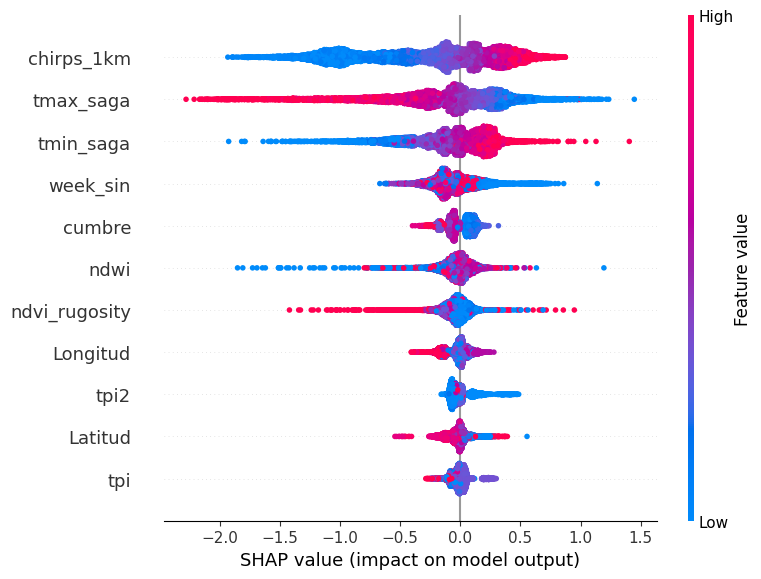

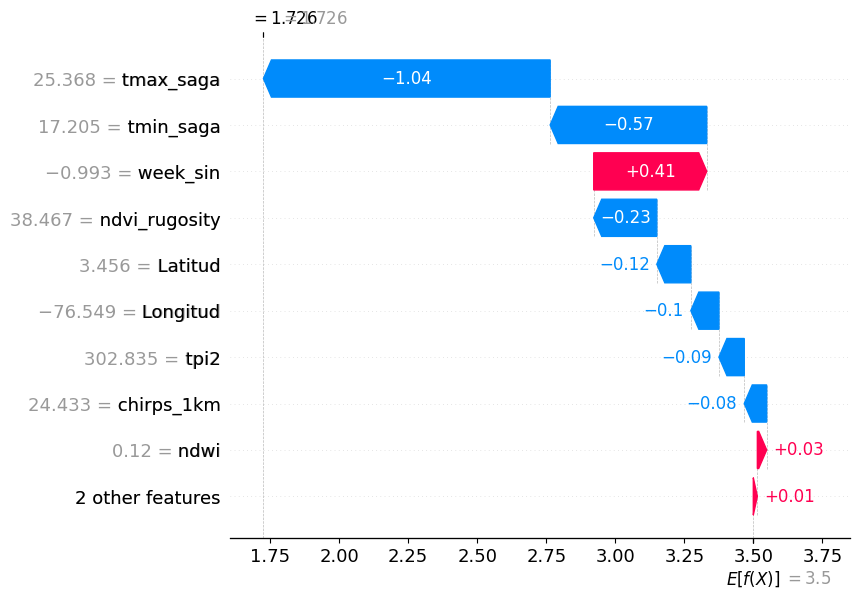

In [17]:
# Supón que ya tienes tu modelo entrenado
# model = xgb.XGBRegressor(...)
# model.fit(X_train, y_train)

# Usar un subconjunto si hay muchos datos
X_sample = X  # opcional, para visualización más rápida

# Crear el objeto SHAP explainer
explainer = shap.Explainer(final_model)

# Calcular los valores SHAP
shap_values = explainer(X_sample)

# Visualización: resumen de importancia global
shap.summary_plot(shap_values, X_sample)

# Visualización: aportes en una predicción individual
shap.plots.waterfall(shap_values[0])

## Resultados mejor modelo Xgboost

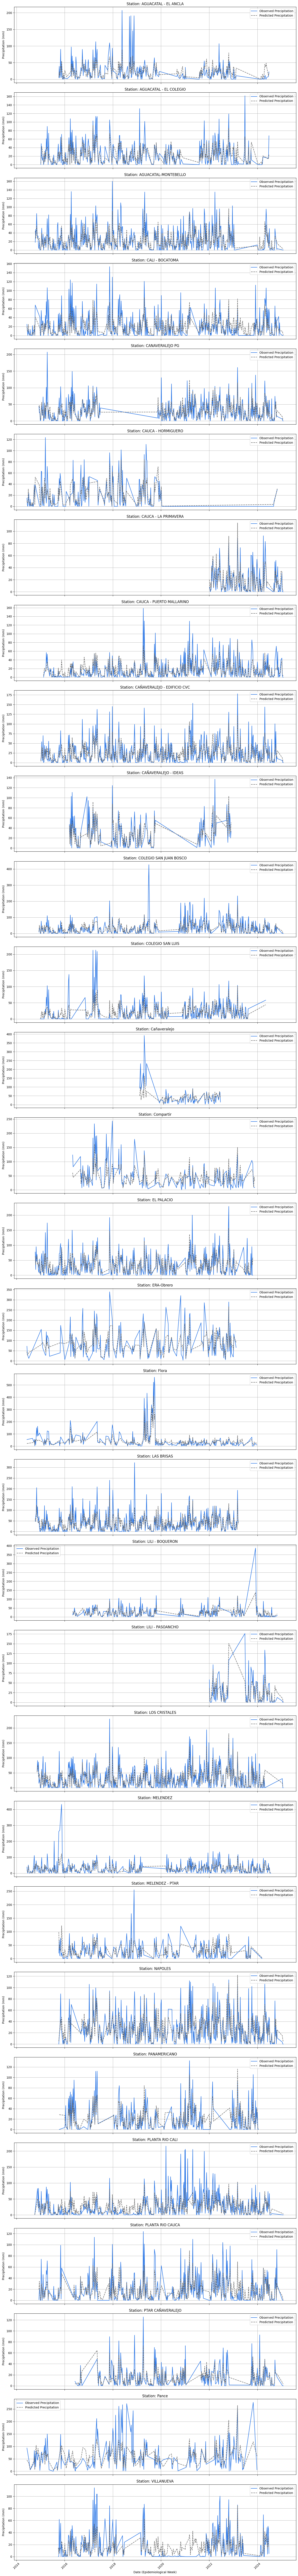

In [18]:
# Usar todos los datos disponibles para todas las estaciones (sin limitar a 50 por estación)
full_plot_data = df.copy()
full_plot_data['Fecha'] = pd.to_datetime(full_plot_data['epi_week'] + '-1', format='%Y-%W-%w', errors='coerce')
full_plot_data = full_plot_data.dropna(subset=['Precipitacion', 'Precipitacion', 'Fecha'])

# Obtener estaciones únicas
stations = full_plot_data['Estacion'].unique()

# Crear un gráfico por estación
fig, axes = plt.subplots(nrows=len(stations), ncols=1, figsize=(14, 4 * len(stations)), sharex=True)

# Asegurar que axes es iterable
if len(stations) == 1:
    axes = [axes]

# Generar los subgráficos
for ax, station in zip(axes, stations):
    data = full_plot_data[full_plot_data['Estacion'] == station]
    ax.plot(data['Fecha'], data['Precipitacion'], label='Observed Precipitation', linestyle='-',color="#2673E5")
    ax.plot(data['Fecha'], data['precip_xgboost'], label='Predicted Precipitation', linestyle='--',color="#696969")
    ax.set_title(f'Station: {station}')
    ax.set_ylabel('Precipitation (mm)')
    ax.legend()
    ax.grid(True)
    ax.tick_params(axis='x', rotation=45)

plt.xlabel("Date (Epidemiological Week)")
plt.tight_layout()
plt.show()

In [19]:
assesment = df[["Estacion","year","week","Precipitacion","chirps_1km","precip_xgboost"]]

# Calcular métricas
def compute_metrics(y_true, y_pred):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    corr, _ = pearsonr(y_true, y_pred)
    bias = np.mean(y_pred - y_true)
    var_ratio = np.var(y_pred) / np.var(y_true)
    return rmse, corr, bias, var_ratio


grouped_results = []

for station, group in assesment.groupby("Estacion"):
    metrics_saga = compute_metrics(group["Precipitacion"], group["chirps_1km"])
    metrics_xgb = compute_metrics(group["Precipitacion"], group["precip_xgboost"])
    improvement = [s - x for s, x in zip(metrics_saga, metrics_xgb)]
    
    for metric, saga_val, xgb_val, imp_val in zip(["RMSE", "Pearson r", "Bias (mean error)", "Variance Ratio"], metrics_saga, metrics_xgb, improvement):
        grouped_results.append({
            "Station": station,
            "Metric": metric,
            "CHIRPS_1km": saga_val,
            "XGBoost": xgb_val,
            "Improvement": imp_val
        })

results_by_station_df = pd.DataFrame(grouped_results)

results_by_station_df

Station             Metric  CHIRPS_1km    XGBoost  \
0      AGUACATAL - EL ANCLA               RMSE   34.928133  23.154348   
1      AGUACATAL - EL ANCLA          Pearson r    0.332525   0.716805   
2      AGUACATAL - EL ANCLA  Bias (mean error)    6.636502  -1.060802   
3      AGUACATAL - EL ANCLA     Variance Ratio    0.716609   0.270592   
4    AGUACATAL - EL COLEGIO               RMSE   25.841234  17.304220   
..                      ...                ...         ...        ...   
115                   Pance     Variance Ratio    0.281136   0.309586   
116              VILLANUEVA               RMSE   28.402885  16.530682   
117              VILLANUEVA          Pearson r    0.486782   0.715566   
118              VILLANUEVA  Bias (mean error)   12.652241  -0.349144   
119              VILLANUEVA     Variance Ratio    1.343486   0.309822   

     Improvement  
0      11.773785  
1      -0.384280  
2       7.697304  
3       0.446017  
4       8.537014  
..           ...  
115    -0.028450  
116    11.872202  
117    -0.228784  
118    13.001385  
119     1.033664  

[120 rows x 5 columns]

In [21]:
## Guarda el  mejor modelo para tmax

dump(final_model, "D:/OneDrive - CGIAR/Desktop/downscaling/models/xgb_precip.joblib")

['D:/OneDrive - CGIAR/Desktop/downscaling/models/xgb_precip.joblib']